In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                (df_sales['item_id']==20949)]
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet


,date,item_cnt_day_total
0,2013-04-24,8.0
1,2013-04-25,25.0
2,2013-04-26,43.0
3,2013-04-27,38.0
4,2013-04-28,38.0
...,...,...
916,2015-10-27,74.0
917,2015-10-28,90.0
918,2015-10-29,92.0
919,2015-10-30,118.0


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet['floor']=0
df_sales_fbprophet['cap']=df_sales_fbprophet['y'].max()
df_sales_fbprophet

,ds,y,floor,cap
0,2013-04-24,8.0,0,1137.0
1,2013-04-25,25.0,0,1137.0
2,2013-04-26,43.0,0,1137.0
3,2013-04-27,38.0,0,1137.0
4,2013-04-28,38.0,0,1137.0
...,...,...,...,...
916,2015-10-27,74.0,0,1137.0
917,2015-10-28,90.0,0,1137.0
918,2015-10-29,92.0,0,1137.0
919,2015-10-30,118.0,0,1137.0


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True, growth='logistic')
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 1 threads.


In [6]:
# find how many periods we need by finding the last day in the item
days_to_predict = pd.to_datetime('2016-1-31') - df_sales_fbprophet['ds'].max()
days_to_predict.days

92

In [7]:
# predict a few days into the future so we have a full month in November
future = m.make_future_dataframe(periods=days_to_predict.days)
future['floor']=0
future['cap']=df_sales_fbprophet['y'].max()

future.tail()

,ds,floor,cap
1008,2016-01-27,0,1137.0
1009,2016-01-28,0,1137.0
1010,2016-01-29,0,1137.0
1011,2016-01-30,0,1137.0
1012,2016-01-31,0,1137.0


In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1008,2016-01-27,12.843777,-101.475748,122.640867
1009,2016-01-28,23.736911,-88.296507,128.289552
1010,2016-01-29,64.884471,-42.358510,166.599783
1011,2016-01-30,142.520244,33.623441,246.644749
1012,2016-01-31,88.856211,-18.361330,205.569009


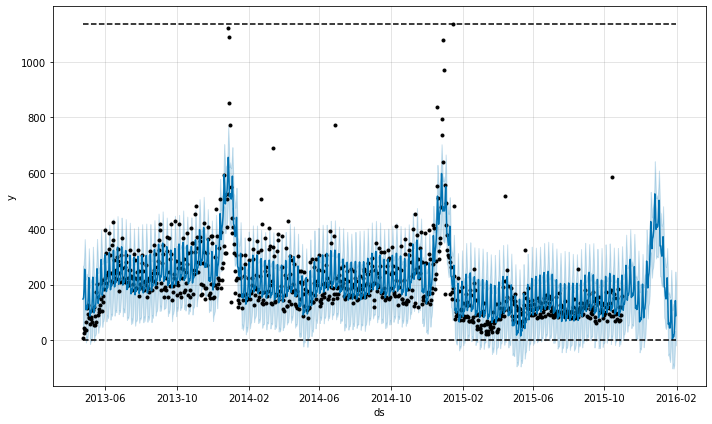

In [9]:
fig1 = m.plot(forecast)

In [10]:
# 30 days of November
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']

921    181.026870
922    107.943542
923    131.288945
924    129.758486
925    144.861178
926    189.275526
927    269.279018
928    217.124571
929    144.010370
930    166.364239
931    162.858258
932    175.005877
933    215.518808
934    290.736746
935    233.003238
936    153.634138
937    169.199798
938    158.536758
939    163.341231
940    196.521754
941    264.624166
942    200.202315
943    114.781106
944    125.133136
945    110.284842
946    112.104619
947    143.650400
948    211.590006
949    148.567819
950     66.164470
Name: yhat, dtype: float64

In [11]:
# forecast for the whole month of November
forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1'))
             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat'].sum()

5096.392229856396